### Загрузка данных

In [1]:
import numpy as np 
import pandas as pd
import matplotlib
import torch
from tqdm import trange
import pandas as pd
from omegaconf import OmegaConf
import os
import sys
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
matplotlib.rcParams['figure.figsize'] = (9,6)
sys.path.insert(0, os.sep.join(os.path.abspath('').split(os.sep)[:-1]))
from preprocessing import do_pipeline

os.chdir(os.path.dirname(os.sep.join(os.path.abspath('').split(os.sep)[:-1])))
cfg = OmegaConf.load("src/config/config.yaml")

Загрузка сырого датасета в csv формате

In [2]:
df_train_path = f"./{cfg.general.data_dir}/prostata_filtered.csv"
df_train = pd.read_csv(df_train_path).drop(columns=["Unnamed: 0.1", "Unnamed: 0"])
train_targets = torch.tensor(df_train["ddg"], dtype=torch.float32)
df_train.head(3)

,wt_seq,mut_seq,ddg,pdb_id,mut_info,pos,id,chain,path,mutations,positions,train_mega,train_ssym,train_s669,mut_type
0,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFSPHCYQFEEVLHISDNV...,-1.800000,1A23,C30S,29,1a23_A_C30S,A,/mnt/nfs_protein/shashkova/AF_toolkit_data/pro...,A:C30S,A:30,True,True,True,ss
1,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHSYQFEEVLHISDNV...,-1.018454,1A23,C33S,32,1a23_A_C33S,A,/mnt/nfs_protein/shashkova/AF_toolkit_data/pro...,A:C33S,A:33,True,True,True,ss
2,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPHCYQFEEVLHISDNV...,AQYEDGKQYTTLEKPVAGAPQVLEFFSFFCPLCYQFEEVLHISDNV...,4.950000,1A23,H32L,31,1a23_A_H32L,A,/mnt/nfs_protein/shashkova/AF_toolkit_data/pro...,A:H32L,A:32,True,True,True,ss


Загрузка даталоадера (обработанные данные, подающиеся на вход нейросети)

In [5]:
# train_dataloader, val_dataloader, test_dataloader = do_pipeline()

# Закешированные даталоадеры для ускорения их загрузки
import pickle
with open(f"./{cfg.general.data_dir}/secondary/dataloaders/dataloaders.pkl", "rb") as file:
    train_dataloader, val_dataloader, test_dataloader = pickle.load(file)

X_train, y_train = train_dataloader.dataset.tensors
X_test, y_test = val_dataloader.dataset.tensors
X_train, y_train, X_test, y_test = X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()

X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

X_df = pd.DataFrame(X)
X_df["ddg"] = y
X_df.shape

(2375, 359)

In [5]:
temp = pd.Series(y.squeeze()).apply(lambda y: -1 if y < 0.5 else 1)
print(f"Доля значений label, равных 1, составляет {round(100 * len(temp[temp == 1]) / len(temp), 2)}%") # дизбаланс классов

Доля значений label, равных 1, составляет 14.53%


## I. Визуализация

#### Удаление высоко скореллированных столбцов c помощью библиотеки FixDQ (fix data quality):

In [12]:
from autoviz import FixDQ

fixdq = FixDQ()
X_df_fixed = fixdq.fit_transform(X_df)
X_df_fixed.columns = [str(i) for i in X_df_fixed.columns]
len(X_df_fixed.columns)

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)
    Dropping 9 which has a high correlation with [7]
    Dropping 10 which has a high correlation with [7, 9]
    Dropping 35 which has a high correlation with [9, 33]
    Dropping 56 which has a high correlation with [9, 30]
    Dropping 68 which has a high correlation with [9, 10, 35]
    Dropping 79 which has a high correlation with [58]
    Dropping 82 which has a high correlation with [30, 56, 58, 79]
    Dropping 87 which has a high correlation with [9, 10, 35, 56, 82]
    Dropping 88 which has a high correlation with [9, 56, 82]
    Dropping 103 which has a high correlation with [9, 10, 35, 56, 58, 68, 79, 82, 87, 88]
    Dropping 114 which has a high correlation with [9, 10, 30, 

223

Нормализация получившихся данных

In [14]:
from sklearn.preprocessing import StandardScaler

X_df_fixed.to_csv(f"./{cfg.general.data_dir}/secondary/csv/X_df_fixed.csv")
X_df_fixed_normalized = pd.DataFrame(StandardScaler().fit_transform(X_df_fixed), columns=X_df_fixed.columns)
X_df_fixed_normalized.to_csv(f"./{cfg.general.data_dir}/secondary/csv/X_df_fixed_normalized.csv")
X_df_fixed_normalized.head(3)

,0,1,2,3,4,5,6,7,8,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,57,58,59,60,61,62,63,64,65,66,67,69,70,71,72,73,74,75,76,77,78,80,81,83,84,85,86,89,90,91,92,93,94,95,96,97,98,99,100,101,102,104,105,106,107,108,109,110,111,112,113,116,119,120,121,122,123,124,125,126,127,128,179,180,181,182,183,184,185,187,190,191,192,193,194,195,196,198,199,200,201,202,203,204,205,206,207,208,210,211,212,213,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,236,238,239,240,241,242,243,244,245,248,249,250,251,252,253,254,255,257,259,260,262,263,264,269,270,271,272,273,274,275,276,277,278,279,280,281,284,285,286,287,288,289,290,291,292,294,295,298,299,300,301,302,303,304,305,306,307,ddg
0,1.239823,2.151412,0.898104,0.305424,0.291504,-0.726489,-0.481676,-0.146730,-2.109806,-0.223474,-1.890314,1.412385,0.934916,0.862276,-0.666509,0.555453,0.748306,-0.399370,-2.008451,-0.366638,-0.551577,0.219333,0.700505,0.215944,0.022284,-0.758100,-2.104035,1.107787,0.021913,1.398679,-1.703176,0.171126,0.528921,0.477568,-0.056720,0.508714,1.932108,0.032761,-0.077539,-1.082882,0.333443,-0.339661,0.273092,-0.159489,1.235928,-0.379068,-0.485506,-1.339850,-0.914595,1.187114,1.422534,0.739172,1.660930,0.607732,-0.561637,-0.228406,-0.603837,-1.107308,-2.124043,-0.432482,0.146070,0.164169,1.241234,-0.374505,-0.093351,2.117576,-0.320867,-0.868147,0.427260,-0.102205,0.630724,1.139500,-0.257596,0.152219,-1.873038,-0.887187,1.600876,0.322152,0.303724,0.342643,-0.197983,-1.819466,-0.555189,0.379331,-0.180418,1.094743,0.330918,1.766324,-1.531337,0.983212,-0.540107,-0.252591,-0.871560,0.321151,-0.159854,0.209750,0.029336,-0.816405,0.536896,-1.116736,-2.062800,0.374557,0.888013,-2.056957,-0.667824,0.335404,0.642217,-0.352912,0.510594,-0.917174,0.698812,0.050111,1.347000,-1.229362,1.925033,1.343018,1.805562,2.770218,0.074866,0.462036,-0.207768,-0.806958,-2.492939,-0.724321,-1.604618,1.439478,0.438242,0.462983,-0.485108,1.042229,-0.185028,-2.403699,-0.082839,-0.262807,-0.340079,0.688784,1.666718,0.294410,-1.593230,-1.594867,-0.560160,1.268188,-0.921335,0.214418,0.607037,0.741695,-0.440282,0.814694,1.098271,-0.095566,-0.917743,-1.208450,0.339203,-0.314904,-0.418519,-0.311090,1.119847,-0.209360,-0.555591,-0.814536,-0.421773,1.282275,1.494414,1.709163,1.369480,0.424658,-0.379219,-0.967362,-1.173949,-1.835541,-0.009366,0.810068,0.268868,1.646615,0.030025,2.151552,-0.393016,-0.253094,-0.125692,0.391211,0.697774,0.326986,0.576606,-1.529832,-1.271088,1.719518,-1.026835,0.644285,-1.694899,-0.504313,0.020920,-0.009674,0.767984,-0.451393,1.546366,-1.980621,1.222716,0.345773,0.593638,-0.946137,-0.051248,0.465097,-0.107405,-1.351884,0.472881,-0.896801,-1.823359,0.131733,0.899831,-1.612416,-0.003182,0.839194,-0.064881,0.417745,0.645708,0.713957,-0.225071,-0.589121,-0.428299,1.281357,-0.577927,1.766502,-0.309355
1,0.482074,0.475984,1.858054,-0.762778,1.340283,0.740505,0.850689,1.223322,-1.435029,0.575209,-1.395272,-1.376468,-0.343857,-0.097281,-0.709362,-1.439270,-0.208549,-0.654542,-0.397696,-0.655046,-0.332865,0.425737,-1.918998,1.135973,0.218268,0.298339,0.642647,-0.304449,-0.286445,0.653102,0.394539,0.948234,-0.074114,0.151984,0.412347,0.970867,-0.491922,-0.751666,1.005687,0.207944,-0.241421,0.232567,0.791998,-0.273486,-0.006644,0.256809,0.113640,-2.117373,0.429090,-0.018970,1.041505,0.305777,1.048669,-0.820570,-0.437099,-1.189487,-1.719697,0.538861,-0.261409,0.690814,0.157011,-0.545557,1.029575,-0.090040,-1.169237,1.368972,-0.542915,-0.777015,0.672551,-0.125366,-0.178602,-0.530573,-0.635489,-1.158950,-1.260096,-0.407988,-0.094705,-0.901725,1.384645,0.778236,-0.647412,-0.270554,0.347502,-0.383751,-0.133492,-0.606958,0.069596,1.215821,-1.040071,-0.862056,0.011197,-0.186692,-0.561977,-0.175276,-0.199135,-0.146495,0.428642,0.254883,0.507621,1.127758,-1.227044,0.126400,-0.068555,-0.745833,-0.385200,-0.776538,0.736361,0.665301,-0.583196,-0.038058,0.509144,-0.842570,0.566412,-0.004

#### Визуализация исходных данных с помощью библиотеки AutoViz

    Since nrows is smaller than dataset, loading random sample of 1000 rows into pandas...
Shape of your Data Set loaded: (1000, 359)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
  Printing up to 30 columns (max) in each category:
    Numeric Columns : ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29']
    Integer-Categorical Columns: []
    String-Categorical Columns: []
    Factor-Categorical Columns: []
    String-Boolean Columns: []
    Numeric-Boolean Columns: []
    Discrete String Columns: []
    NLP text Columns: []
    Date Time Columns: []
    ID Columns: []
    Columns that will not be considered in modeli

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
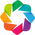

Saving scatterplots in HTML format


Saving pair_scatters in HTML format


Saving distplots_nums in HTML format


Saving kde_plots in HTML format


Saving violinplots in HTML format


Saving heatmaps in HTML format
Time to run AutoViz (in seconds) = 240


In [18]:
%matplotlib inline

#Load Autoviz
from autoviz import AutoViz_Class

target_variable = "ddg"
os.makedirs("logs/autoviz", exist_ok=True)

AV = AutoViz_Class()
dft = AV.AutoViz(
    "",
    sep=",",
    depVar=target_variable,
    dfte=X_df,
    header=0,
    verbose=2,
    lowess=False,
    chart_format="html",
    max_cols_analyzed=30,
    max_rows_analyzed=1000,
    save_plot_dir="src/logs/autoviz"
)

#### Визуализация с помощью библиотеки dtale

In [3]:
import dtale

d = dtale.show(df_train)
d.open_browser()

In [6]:
import dtale

d = dtale.show(X_df)
d.open_browser()

#### Визуализация с помощью библиотеки sweetviz наиболее важных признаков (использовавшихся наиболее часто при сплитах в градиентном бустинге на решающих деревьях)
P.s. Список этих признаков был взят из логов работы библиотеки AutoFiz. Ниже представлен отрывок из них:

```
################ Regression problem #####################
Number of variables = 358 exceeds limit, finding top 30 variables through XGBoost
    No categorical feature reduction done. All 0 Categorical vars selected 
    Removing correlated variables from 358 numerics using SULO method

After removing highly correlated variables, following 112 numeric vars selected: ['0', '2', '12', '15', '19', '24', '25', '28', '29', '40', '41', '45', '53', '63', '64', '69', '78', '80', '84', '85', '99', '108', '124', '179', '181', '191', '194', '198', '203', '207', '208', '210', '219', '220', '224', '232', '242', '243', '248', '257', '259', '263', '264', '278', '287', '303', '86', '101', '20', '51', '1', '253', '50', '110', '13', '107', '97', '269', '83', '239', '221', '3', '75', '65', '38', '279', '112', '22', '251', '277', '6', '14', '71', '61', '204', '55', '231', '216', '273', '190', '95', '225', '128', '288', '16', '238', '121', '21', '202', '76', '47', '111', '184', '252', '218', '304', '281', '275', '70', '27', '120', '284', '91', '62', '187', '113', '116', '122', '126']
    Adding 0 categorical variables to reduced numeric variables  of 112
############## F E A T U R E   S E L E C T I O N  ####################
Current number of predictors = 112 
    Finding Important Features using Boosted Trees algorithm...
        using 112 variables...
        using 90 variables...
        using 68 variables...
        using 46 variables...
        using 24 variables...
        using 2 variables...
Found 48 important features
    Since number of features selected is greater than max columns analyzed, limiting to 30 variables
```

In [24]:
import sweetviz as sv


most_important_features = ['0', '2', '12', '15', '19', '24', '25', '28', '29', '40', '41', '45', '53', '63', '64', '69', '78', '80', '84', '85', '99', '108', '124', '179', '181', '191', '194', '198', '203', '207', '208', '210', '219', '220', '224', '232', '242', '243', '248', '257', '259', '263', '264', '278', '287', '303', '86', '101', '20', '51', '1', '253', '50', '110', '13', '107', '97', '269', '83', '239', '221', '3', '75', '65', '38', '279', '112', '22', '251', '277', '6', '14', '71', '61', '204', '55', '231', '216', '273', '190', '95', '225', '128', '288', '16', '238', '121', '21', '202', '76', '47', '111', '184', '252', '218', '304', '281', '275', '70', '27', '120', '284', '91', '62', '187', '113', '116', '122', '126']
X_df_fixed[most_important_features]

report = sv.analyze(X_df_fixed[most_important_features])
os.makedirs("src/logs/sweetviz", exist_ok=True)
report.show_html("src/logs/sweetviz/sweetviz_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report src/logs/sweetviz/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#### Визуализация с помощью библиотеки ydata_profiling наиболее важных признаков (использовавшихся наиболее часто при сплитах в градиентном бустинге на решающих деревьях)

In [25]:
from ydata_profiling import ProfileReport

profile = ProfileReport(X_df_fixed[most_important_features], title="Pandas Profiling Report")
os.makedirs("src/logs/ydata_profiling", exist_ok=True)
profile.to_file("src/logs/ydata_profiling/ydata_profiling-X_df_fixed.html")
profile

2024-09-10 06:48:45,897 - INFO     - Pandas backend loaded 2.2.2
2024-09-10 06:48:45,911 - INFO     - Numpy backend loaded 1.26.4
2024-09-10 06:48:45,913 - INFO     - Pyspark backend NOT loaded
2024-09-10 06:48:45,913 - INFO     - Python backend loaded


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### PCA для наиболее важных признаков (использовавшихся наиболее часто при сплитах в градиентном бустинге на решающих деревьях)
P.s. Было попробовано разное кол-во главных компонент (в том числе равное исходному кол-ву признаков), но ни один из получившихся датасетов не показал лУчшие или такие же метрики.

PCA без усечения главных компонент с малыми собственными значениями

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(most_important_features), whiten=False, random_state=42)

X_df_fixed_pca = pd.DataFrame(pca.fit_transform(X_df_fixed[most_important_features], y=X_df_fixed['ddg']), columns=X_df_fixed[most_important_features].columns)
X_df_fixed_pca.to_csv(f"./{cfg.general.data_dir}/secondary/csv/X_df_fixed_pca.csv", index=False)
X_df_fixed_pca

,0,2,12,15,19,24,25,28,29,40,41,45,53,63,64,69,78,80,84,85,99,108,124,179,181,191,194,198,203,207,208,210,219,220,224,232,242,243,248,257,259,263,264,278,287,303,86,101,20,51,1,253,50,110,13,107,97,269,83,239,221,3,75,65,38,279,112,22,251,277,6,14,71,61,204,55,231,216,273,190,95,225,128,288,16,238,121,21,202,76,47,111,184,252,218,304,281,275,70,27,120,284,91,62,187,113,116,122,126
0,4.636322,156.379272,-129.503357,43.703613,-45.448914,63.776886,-50.663757,4.324738,-5.888885,22.818787,-5.900604,-33.575085,29.224043,35.889893,23.327496,-16.643250,-26.096680,-5.271439,51.147812,-5.576237,2.170273,-6.962915,8.042297,-5.063850,1.591692,18.483978,13.379326,18.838608,9.618242,14.652809,-11.430740,2.328671,6.945152,-7.060556,-19.086401,28.532486,2.290066,-0.949554,4.967983,-16.832773,4.394493,-5.985718,-11.787163,4.308084,14.678493,2.936201,-4.865959,10.607143,-1.728670,-3.993736,-10.514425,-0.707257,10.691431,5.978141,-11.939960,-6.263512,0.825640,-14.115985,-0.077618,-2.676071,1.752892,5.370403,-1.608864,-6.866685,-11.716518,-12.438892,-5.692413,-3.393456,0.073795,-0.837396,-18.842484,-3.103794,1.761055,2.540594,-0.577656,13.850938,8.584538,-14.153969,0.252785,13.110644,-2.475674,-1.360186,10.180550,9.684366,11.688812,-4.702324,-4.020618,-5.114744,3.343201,-4.842941,-4.266878,-1.728298,-2.164551,1.935154,6.501106,-3.388903,1.676034,5.021098,6.785954,2.495995,-4.651039,2.221481,-4.084732,3.130464,8.440787,-1.172307,-3.625544,1.944955,-0.032201
1,40.039764,59.066284,-5.504944,9.747498,-76.932312,55.709724,-53.127686,-13.970993,-29.073090,-7.453278,36.921921,43.670830,19.161989,-21.826492,-27.139256,16.096619,17.406250,-2.011124,48.254547,-26.159477,-10.591354,21.005960,-27.347542,-15.371361,14.739447,1.052383,4.163754,-15.159775,11.059933,12.249908,1.018921,2.771030,-26.169601,15.082685,-5.387078,1.527489,-7.811039,-6.116440,-9.456184,9.146894,-11.235779,-9.161804,10.215569,8.791175,1.002426,0.762473,-4.964066,9.305562,19.701626,-1.934242,-9.690098,-12.116693,-14.909477,-4.486294,-1.311787,9.174591,5.120300,3.192715,12.614101,4.152885,-8.917875,3.113955,-6.676861,1.779282,2.347876,7.537094,-1.119484,-6.872581,-7.930614,-10.896409,8.125883,-2.717449,-9.700569,-2.420546,3.602016,12.108939,-1.199055,-1.203499,4.900864,-1.357766,8.085796,-0.636253,-5.872528,-4.271487,-2.863118,-6.893426,10.016663,-8.442211,-6.844620,6.746178,-6.346774,-0.891495,4.418619,-4.359833,0.881971,-1.219775,6.811613,1.351723,-2.124168,-9.437262,1.837319,3.641106,-1.839977,5.762573,-0.408486,1.450400,-1.329220,-0.860341,0.001016
2,146.158875,43.421875,-58.590942,46.874847,57.512512,-15.590973,18.059753,31.007446,31.064606,28.409393,21.315689,-25.586866,-9.393682,-45.473770,17.762394,-2.040009,-21.873444,-25.344833,-13.691620,-22.345871,-0.340820,-3.321688,16.530281,-22.392273,13.946125,13.571930,-6.143688,-10.093002,-10.063721,4.856667,25.824562,16.123871,12.676743,3.581761,17.544250,15.710144,-6.417980,4.717392,-12.266445,-19.239172,17.605438,-15.783463,-1.644585,-14.973873,-11.780064,0.212275,-5.515686,4.098329,12.787605,-9.592018,-9.074377,-0.815041,0.861401,-2.559439,-0.488014,-7.784264,-6.699173,-6.598271,14.441505,2.727394,-2.816351,-4.136557,-4.669422,12.829613,-2.635738,7.446594,-2.001549,-9.886101,16.819412,-2.598610,14.081825,-1.737253,0.507545,-0.514404,-10.470951,11.920568,-1.964855,-6.747097,7.093430,-9.499623,-6.029236,18.571674,4.794289,3.396944,5.779720,4.034215,3.378490,3.700106,1.033451,1.020432,-1.731524,-5.875887,5.183195,-6.097416,3.526056,-4.595016,-3.406026,-0.342677,-4.822834,1.819162,0.546160,9.738874,-5.479057,-2.618404,11.824330,-0.460795,0.642783,-0.606684,-0.019805
3,-40.971497,83.199097,8.405273,19.913849,-37.652649,76.199547,-29.711182,24.287903,17.596649,-36.120468,12.917770,-5.145342,6.396173,-33.803665,46.922199,27.319672,-3.514755,-0.556534,21.517006,27.448673,12.210526,-8.616243,15.356789,14.794350,-21.519606,-0.780396,4.223026,3.847000,-6.753382,-17.323112,5.251564,9.493427,-13.663910,-5.784995,-16.186649,-7.877022,-8.076851,-17

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30, whiten=False, random_state=42)

X_df_fixed_pca = pd.DataFrame(pca.fit_transform(X_df_fixed[most_important_features], y=X_df_fixed['ddg']), columns=X_df_fixed[most_important_features].columns)
X_df_fixed_pca.to_csv(f"./{cfg.general.data_dir}/secondary/csv/X_df_fixed_pca_n=30.csv", index=False)

P.s. Визуализация PCA для n_components = 30 (92.3% of total variance)

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed on the [358] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[30]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 30 Principal Components explain [92.30%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

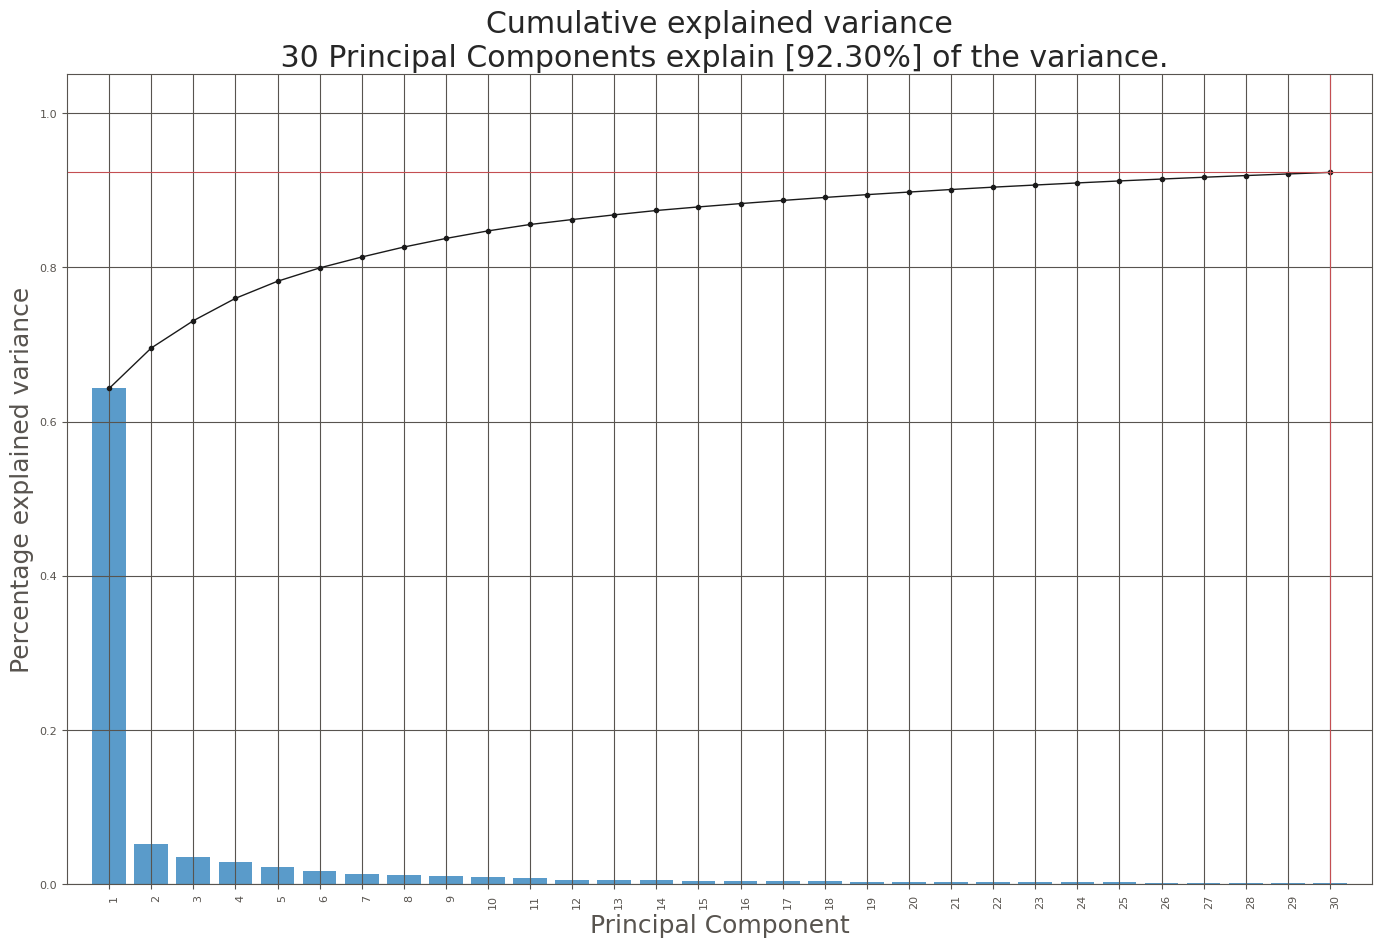

In [89]:
from pca import pca
%matplotlib inline
model = pca(n_components=30)
out = model.fit_transform(X_df.drop(columns=['ddg']))
model.plot()

### II. Очистка данных от выбросов
P.s. Сохраненные датасеты, очищенные от выбросов разными способами, были использованы для обучения нейросети, но ни один из способов не показал лУчшие или такие же метрики.  
P.s.s. Вывод: выбросы в датасете, хорошо видимые при визуализации, являются в действительности не выбросами, а важными данными, информативными для модели.

1. Удаление 1ого и 99ого квантиля (в каждом столбце независимо)

In [8]:
import pandas as pd
import numpy as np

df = pd.DataFrame(np.random.randn(1000, 150) * 100)  # 1000 строк и 150 столбцов

def remove_outliers(df, lower_quantile=0.01, upper_quantile=0.99, max_outlier_columns=0.1):
    outlier_mask = pd.DataFrame(False, index=df.index, columns=df.columns)

    for column in df.columns:
        lower_bound = df[column].quantile(lower_quantile)
        upper_bound = df[column].quantile(upper_quantile)

        outlier_mask[column] = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Считаем, сколько столбцов с выбросами в каждой строке
    outlier_counts = outlier_mask.sum(axis=1)
    #print(outlier_counts.shape)

    max_outliers = int(max_outlier_columns * len(df.columns))
    #print(max_outliers)

    return df[outlier_counts <= max_outliers]


max_outlier_columns = 0.1  # Максимально допустимая доля столбцов с выбросами в строке
# Удаление выбросов (1% снизу и 1% сверху), удаляем строки, если выбросы в более чем 10% столбцов
df_clean = remove_outliers(df, lower_quantile=0.01, upper_quantile=0.99, max_outlier_columns=max_outlier_columns)
X_df_clean = remove_outliers(X_df, lower_quantile=0.01, upper_quantile=0.99, max_outlier_columns=max_outlier_columns)



print(len(df))
print(len(df_clean))
print(f"Осталось: {100 * len(df_clean) / len(df)}%\n")

print(len(X_df))
print(len(X_df_clean))
print(f"Осталось: {100 * len(X_df_clean) / len(X_df)}%")
os.makedirs(f"./{cfg.general.data_dir}/secondary/csv", exist_ok=True)
X_df_clean.to_csv(f"./{cfg.general.data_dir}/secondary/csv/prostata_filtered_remove_top1%_max_outlier_columns_0.1.csv", index=False)

1000
1000
Осталось: 100.0%

2375
2307
Осталось: 97.13684210526316%


2. Находим выбросы внутри вхостов. Т.е. происходит сбор значений 1ого и 99ого квантилей и удаление хвостов в получившимся распределении квантилей (z-score > 3). В каждом столбце независимо

In [9]:
import pandas as pd
import numpy as np
from scipy import stats

df = pd.DataFrame(np.random.randn(1000, 150) * 100)

def remove_extreme_outliers(df, lower_quantile=0.01, upper_quantile=0.99, z_threshold=3):
    outlier_mask = pd.DataFrame(False, index=df.index, columns=df.columns)

    for column in df.columns:
        lower_bound = df[column].quantile(lower_quantile)
        upper_bound = df[column].quantile(upper_quantile)
        
        lower_tail = df[df[column] < lower_bound][column]
        upper_tail = df[df[column] > upper_bound][column]

        # Второй этап: находим выбросы внутри хвостов с помощью Z-оценки
        if not lower_tail.empty:
            lower_tail_z = np.abs(stats.zscore(lower_tail))
            outlier_mask.loc[lower_tail.index, column] = lower_tail_z > z_threshold
        
        if not upper_tail.empty:
            upper_tail_z = np.abs(stats.zscore(upper_tail))
            outlier_mask.loc[upper_tail.index, column] = upper_tail_z > z_threshold

    return df[~outlier_mask.any(axis=1)]


df_clean = remove_extreme_outliers(df, lower_quantile=0.01, upper_quantile=0.99)
X_df_clean = remove_extreme_outliers(X_df, lower_quantile=0.01, upper_quantile=0.99)

print(len(df))
print(len(df_clean))
print(f"Осталось: {100 * len(df_clean) / len(df)}%\n")

print(len(X_df))
print(len(X_df_clean))
print(f"Осталось: {100 * len(X_df_clean) / len(X_df)}%")
X_df_clean.to_csv(f"./{cfg.general.data_dir}/secondary/csv/prostata_filtered_remove_top1%_z=3.csv", index=False)

1000
1000
Осталось: 100.0%

2375
2271
Осталось: 95.62105263157895%


3. Удаление крайних 5% значений в сжатом UMAP-пространстве (гипотеза заключалась в том, что выбросы в 358dim пространстве останутся выбросами и в сжатом 3dim пространстве)

In [10]:
import pandas as pd
import numpy as np
import umap

def remove_outliers_umap(df, n_components=3, percentile_threshold=95):
    """
    Удаляет выбросы из DataFrame, используя UMAP для преобразования данных в 3D-пространство
    и расстояния от центра для определения выбросов.
    """
    umap_model = umap.UMAP(n_components=n_components)
    embedding = umap_model.fit_transform(df)

    mean_point = np.mean(embedding, axis=0)
    distances = np.linalg.norm(embedding - mean_point, axis=1)

    threshold = np.percentile(distances, percentile_threshold)

    is_not_outlier = distances <= threshold
    df_filtered = df[is_not_outlier]

    return df_filtered


df_clean = remove_outliers_umap(df)
X_df_clean = remove_outliers_umap(X_df)

print(len(df))
print(len(df_clean))
print(f"Осталось: {100 * len(df_clean) / len(df)}%\n")

print(len(X_df))
print(len(X_df_clean))
print(f"Осталось: {100 * len(X_df_clean) / len(X_df)}%")
X_df_clean.to_csv(f"./{cfg.general.data_dir}/secondary/csv/prostata_filtered_remove_umap_outliers.csv", index=False)

1000
950
Осталось: 95.0%

2375
2256
Осталось: 94.98947368421052%


4. Удаление значений в сжатом UMAP-пространстве, которые не сгруппировались в большие кластеры

In [11]:
import umap
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

def remove_outliers_with_umap_dbscan(df, n_neighbors=15, min_dist=0.1, n_components=3, eps=0.5, min_samples=5):
    """
    Функция для удаления выбросов из DataFrame, основанная на проекции данных в 3D-пространство с использованием UMAP
    и кластеризации методом DBSCAN для определения выбросов.
    """

    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(df)

    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(embedding)

    # Точки, которые классифицируются как выбросы (имеют метку -1)
    df_cleaned = df[labels != -1]

    return df_cleaned


df_clean = remove_outliers_with_umap_dbscan(df, eps=0.4, min_samples=5)
X_df_clean = remove_outliers_with_umap_dbscan(X_df, eps=0.4, min_samples=5)

print(len(df))
print(len(df_clean))
print(f"Осталось: {100 * len(df_clean) / len(df)}%\n")

print(len(X_df))
print(len(X_df_clean))
print(f"Осталось: {100 * len(X_df_clean) / len(X_df)}%")
X_df_clean.to_csv(f"./{cfg.general.data_dir}/secondary/csv/prostata_filtered_remove_umap_outliers.csv", index=False)

1000
1000
Осталось: 100.0%

2375
2356
Осталось: 99.2%


### III. Добавление данных
P.s. Было замечено, что эти колонки исходного (сырого) датасета не используются при препроцессинге данных. Были рассмотрены 2 варианта добавления их в итоговый датасет:

1. Выбор колонок с количественными признаками + колонки с категориальными признаками, количество уникальных значений которых не более 10% от размера исходного датасета (до 200 категорий)
2. Выбор колонок с количественными признаками + колонки с категориальными признаками, количество уникальных значений которых не более 10

1ый вариант представлен ниже т.к. прост в реализации. Продолжение (2ой вариант) находится в другом ноутбуке той же папки, но он не приведен в надлежащее состояние.

In [19]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

X_add = df_train[['wt_seq', 'pdb_id', 'chain', 'positions']]
for col in X_add.columns:
    X_add[col] = labelencoder.fit_transform(X_add[col])
X_add

,wt_seq,pdb_id,chain,positions
0,18,0,2,165
1,18,0,2,175
2,18,0,2,169
3,18,0,2,169
4,150,1,2,126
...,...,...,...,...
2370,95,170,2,86
2371,95,170,2,151
2372,13,171,2,104
2373,13,171,2,93


In [20]:
concatenated_df = pd.concat([X_df, X_add["chain"], df_train['pos']], axis=1)
concatenated_df.shape
concatenated_df.to_csv(f"./{cfg.general.data_dir}/secondary/csv/prostata_concatenated_360features.csv", index=False)